In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


41

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(1,33):
  print('Person No.' + str(person))


  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']

  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.1
Person No.2
Person No.3
Person No.4
Person No.5
Person No.6
Person No.7
Person No.8
Person No.9
Person No.10
Person No.11
Person No.12
Person No.13
Person No.14
Person No.15
Person No.16
Person No.17
Person No.18
Person No.19
Person No.20
Person No.21
Person No.22
Person No.23
Person No.24
Person No.25
Person No.26
Person No.27
Person No.28
Person No.29
Person No.30
Person No.31
Person No.32
(38400, 36, 256)
(38400,) (16680,) (21720,)
(38400,) (15780,) (22620,)


0

In [ ]:
def simple_2D_CNN(x):
  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(36,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 16, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 32, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 32, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 32, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model():
  input_shape = (36, 256, 1)
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 36, 1, 1)    0           ['input_2[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 36)           0           ['average_pooling2d_1[0][0]']    
                                                                                            

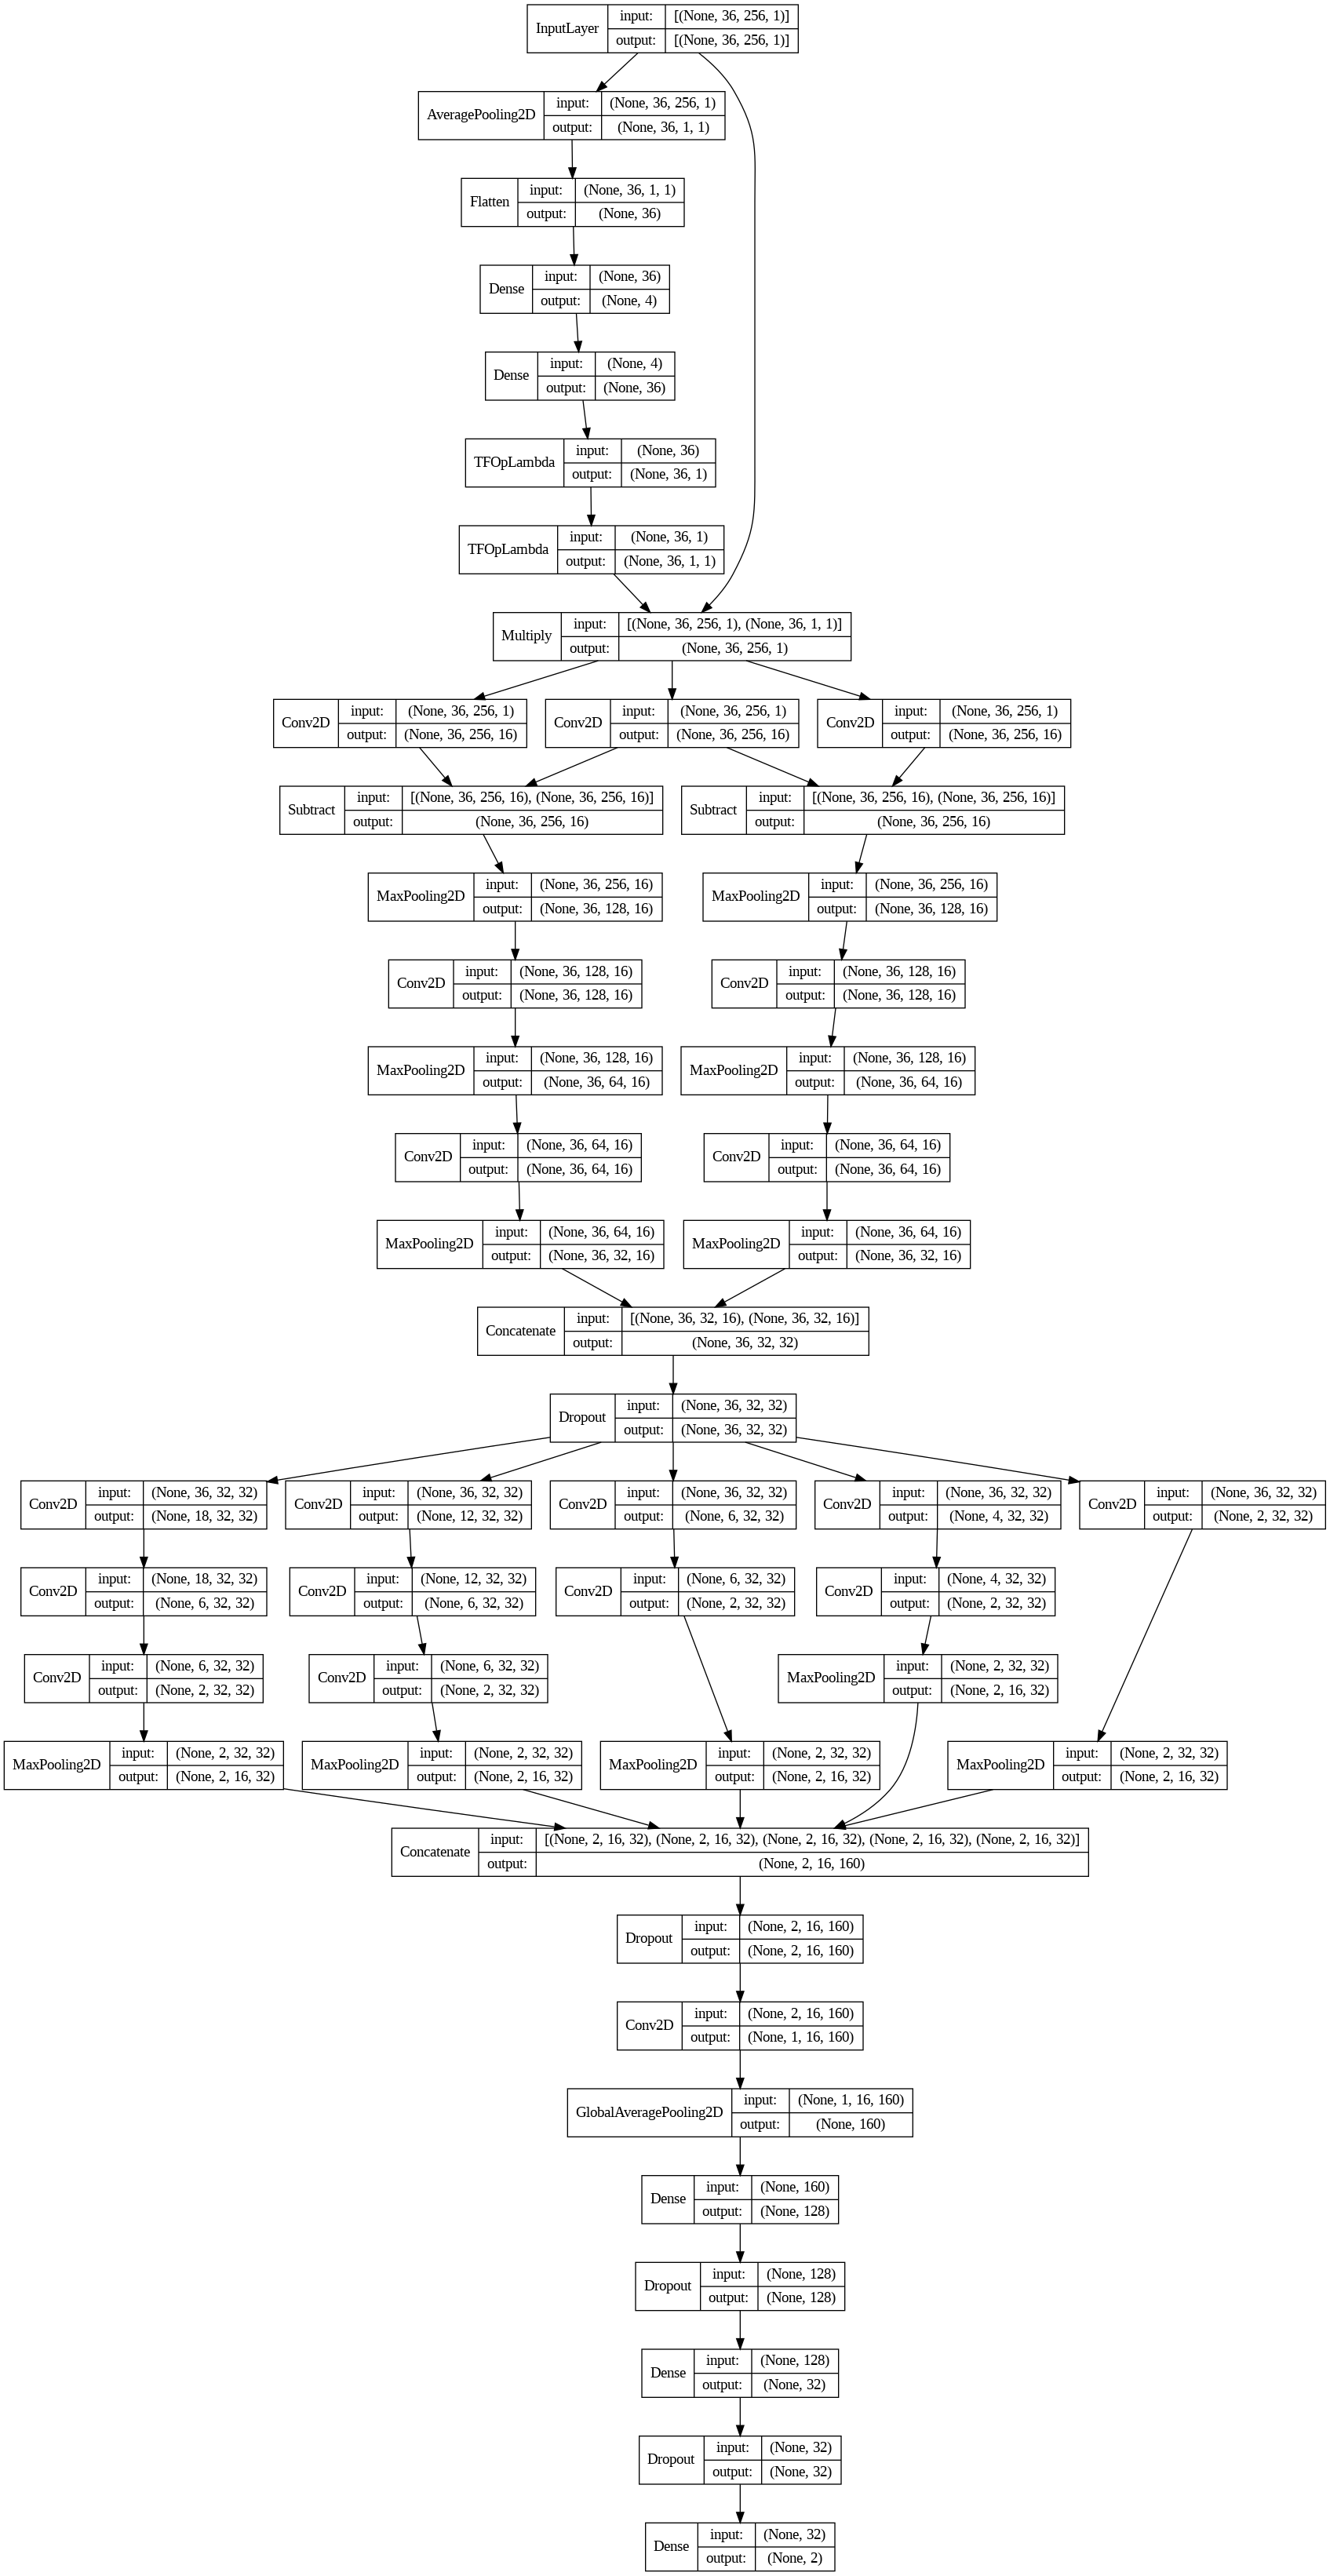

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 30
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

4069

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(34560, 36, 256) (3840, 36, 256) (34560, 2) (3840, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/30
486/486 [==============================] - 49s 62ms/step - loss: 0.6850 - accuracy: 0.5484 - val_loss: 0.6789 - val_accuracy: 0.5631
Epoch 2/30
486/486 [==============================] - 31s 64ms/step - loss: 0.6315 - accuracy: 0.6412 - val_loss: 0.5695 - val_accuracy: 0.6933
Epoch 3/30
486/486 [==============================] - 31s 63ms/step - loss: 0.5508 - accuracy: 0.7123 - val_loss: 0.5101 - val_accuracy: 0.7419
Epoch 4/30
486/486 [==============================] - 31s 64ms/step - loss: 0.4666 - accuracy: 0.7771 - val_loss: 0.4373 - val_accuracy: 0.7833
Epoch 5/30
486/486 [==============================] - 31s 63ms/step - loss: 0.4003 - accuracy: 0.8173 - val_loss: 0.4361 - val_accuracy: 0.7867
Epoch 6/30
486/486 [==============================] - 31s 64ms/step - loss: 0.3446 - accuracy: 0.8474 - val_loss: 0.3613 - val_accuracy: 0.8299
Epoch 7/30
486/486 [==============================] - 31s 64ms/step - loss: 0.3044 - accuracy: 0.8668 - val_loss: 0.3

KeyboardInterrupt: ignored

Accuracy  : 0.9149999916553497
F1_Score  : 0.9127174711685322


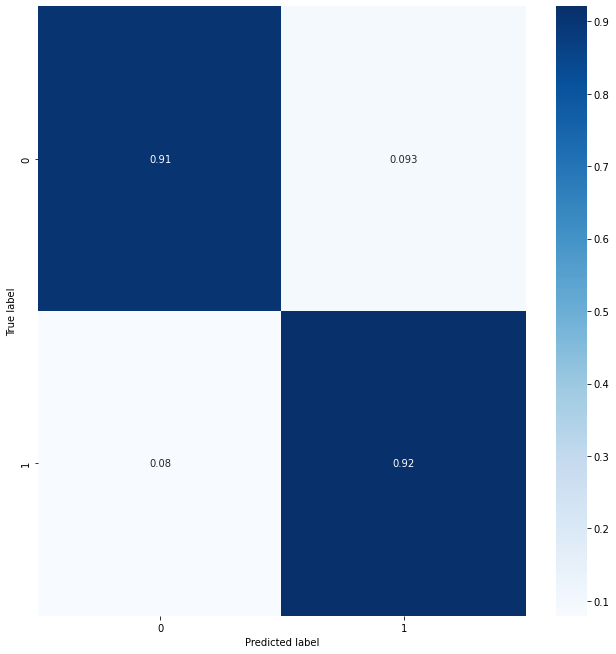

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(34560, 36, 256) (3840, 36, 256) (34560, 2) (3840, 2)


Results for fold 1
Epoch 1/30
486/486 [==============================] - 53s 107ms/step - loss: 0.6422 - accuracy: 0.6251 - val_loss: 0.5943 - val_accuracy: 0.6930
Epoch 2/30
486/486 [==============================] - 52s 106ms/step - loss: 0.5565 - accuracy: 0.7154 - val_loss: 0.4709 - val_accuracy: 0.7830
Epoch 3/30
486/486 [==============================] - 53s 109ms/step - loss: 0.4208 - accuracy: 0.8064 - val_loss: 0.3659 - val_accuracy: 0.8322
Epoch 4/30
486/486 [==============================] - 52s 106ms/step - loss: 0.3115 - accuracy: 0.8667 - val_loss: 0.3126 - val_accuracy: 0.8585
Epoch 5/30
486/486 [==============================] - 52s 106ms/step - loss: 0.2316 - accuracy: 0.9031 - val_loss: 0.3297 - val_accuracy: 0.8646
Epoch 6/30
486/486 [==============================] - 53s 109ms/step - loss: 0.1731 - accuracy: 0.9313 - val_loss: 0.2877 - val_accuracy: 0.8819
Epoch 7/30
486/486 [==============================] - 52s 106ms/step - loss: 0.1344 - accuracy: 0.9461 - val_lo

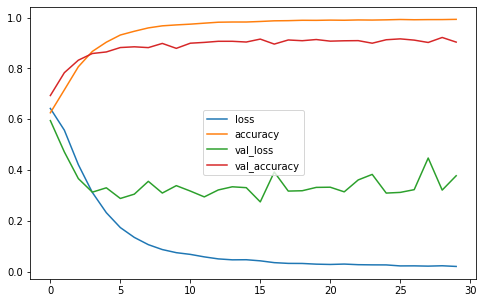

Results for fold 2
Epoch 1/30
486/486 [==============================] - 54s 107ms/step - loss: 0.6432 - accuracy: 0.6247 - val_loss: 0.6150 - val_accuracy: 0.6571
Epoch 2/30
486/486 [==============================] - 52s 106ms/step - loss: 0.5563 - accuracy: 0.7130 - val_loss: 0.5188 - val_accuracy: 0.7300
Epoch 3/30
486/486 [==============================] - 53s 109ms/step - loss: 0.4277 - accuracy: 0.8003 - val_loss: 0.4068 - val_accuracy: 0.8047
Epoch 4/30
486/486 [==============================] - 52s 106ms/step - loss: 0.3265 - accuracy: 0.8572 - val_loss: 0.3691 - val_accuracy: 0.8385
Epoch 5/30
486/486 [==============================] - 52s 106ms/step - loss: 0.2544 - accuracy: 0.8936 - val_loss: 0.3387 - val_accuracy: 0.8547
Epoch 6/30
486/486 [==============================] - 53s 109ms/step - loss: 0.2004 - accuracy: 0.9163 - val_loss: 0.3259 - val_accuracy: 0.8646
Epoch 7/30
486/486 [==============================] - 52s 106ms/step - loss: 0.1520 - accuracy: 0.9394 - val_lo

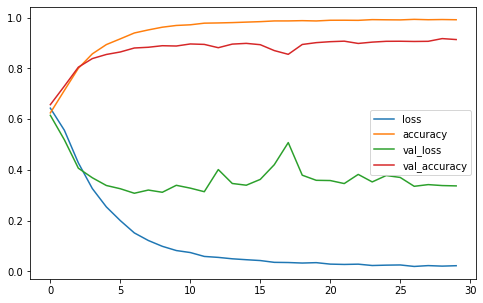

Results for fold 3
Epoch 1/30
486/486 [==============================] - 54s 107ms/step - loss: 0.6361 - accuracy: 0.6342 - val_loss: 0.6027 - val_accuracy: 0.6759
Epoch 2/30
486/486 [==============================] - 53s 109ms/step - loss: 0.5353 - accuracy: 0.7276 - val_loss: 0.4973 - val_accuracy: 0.7480
Epoch 3/30
486/486 [==============================] - 52s 107ms/step - loss: 0.4063 - accuracy: 0.8143 - val_loss: 0.3951 - val_accuracy: 0.8108
Epoch 4/30
486/486 [==============================] - 53s 109ms/step - loss: 0.3050 - accuracy: 0.8670 - val_loss: 0.3409 - val_accuracy: 0.8446
Epoch 5/30
486/486 [==============================] - 52s 107ms/step - loss: 0.2351 - accuracy: 0.9020 - val_loss: 0.2853 - val_accuracy: 0.8799
Epoch 6/30
486/486 [==============================] - 53s 109ms/step - loss: 0.1831 - accuracy: 0.9252 - val_loss: 0.2583 - val_accuracy: 0.8892
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1426 - accuracy: 0.9417 - val_lo

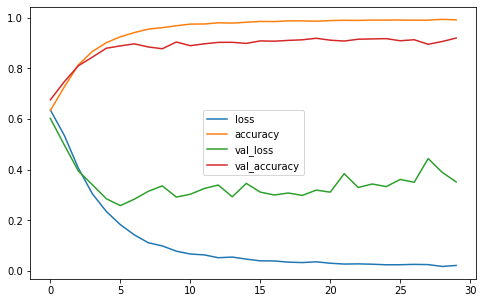

Results for fold 4
Epoch 1/30
486/486 [==============================] - 54s 108ms/step - loss: 0.6394 - accuracy: 0.6266 - val_loss: 0.5861 - val_accuracy: 0.6889
Epoch 2/30
486/486 [==============================] - 52s 107ms/step - loss: 0.5382 - accuracy: 0.7277 - val_loss: 0.4652 - val_accuracy: 0.7804
Epoch 3/30
486/486 [==============================] - 52s 107ms/step - loss: 0.4011 - accuracy: 0.8164 - val_loss: 0.4030 - val_accuracy: 0.8189
Epoch 4/30
486/486 [==============================] - 52s 107ms/step - loss: 0.3015 - accuracy: 0.8699 - val_loss: 0.3747 - val_accuracy: 0.8336
Epoch 5/30
486/486 [==============================] - 52s 107ms/step - loss: 0.2288 - accuracy: 0.9048 - val_loss: 0.3371 - val_accuracy: 0.8588
Epoch 6/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1737 - accuracy: 0.9303 - val_loss: 0.3313 - val_accuracy: 0.8750
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1396 - accuracy: 0.9451 - val_lo

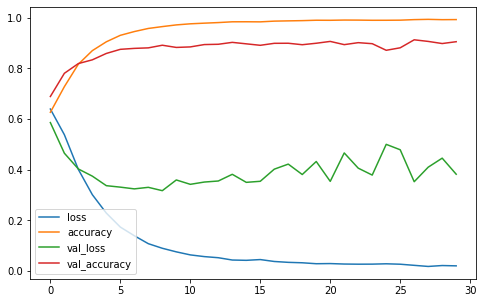

Results for fold 5
Epoch 1/30
486/486 [==============================] - 54s 108ms/step - loss: 0.6362 - accuracy: 0.6265 - val_loss: 0.5739 - val_accuracy: 0.7008
Epoch 2/30
486/486 [==============================] - 52s 107ms/step - loss: 0.5267 - accuracy: 0.7316 - val_loss: 0.4286 - val_accuracy: 0.8032
Epoch 3/30
486/486 [==============================] - 52s 107ms/step - loss: 0.3986 - accuracy: 0.8177 - val_loss: 0.3469 - val_accuracy: 0.8394
Epoch 4/30
486/486 [==============================] - 53s 110ms/step - loss: 0.2979 - accuracy: 0.8712 - val_loss: 0.3036 - val_accuracy: 0.8660
Epoch 5/30
486/486 [==============================] - 53s 110ms/step - loss: 0.2277 - accuracy: 0.9051 - val_loss: 0.3019 - val_accuracy: 0.8764
Epoch 6/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1733 - accuracy: 0.9292 - val_loss: 0.3268 - val_accuracy: 0.8666
Epoch 7/30
486/486 [==============================] - 53s 110ms/step - loss: 0.1364 - accuracy: 0.9448 - val_lo

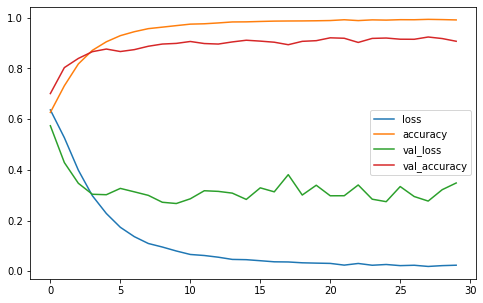

Results for fold 6
Epoch 1/30
486/486 [==============================] - 54s 108ms/step - loss: 0.6407 - accuracy: 0.6259 - val_loss: 0.5840 - val_accuracy: 0.6933
Epoch 2/30
486/486 [==============================] - 53s 110ms/step - loss: 0.5452 - accuracy: 0.7238 - val_loss: 0.5169 - val_accuracy: 0.7546
Epoch 3/30
486/486 [==============================] - 52s 107ms/step - loss: 0.4065 - accuracy: 0.8165 - val_loss: 0.3701 - val_accuracy: 0.8356
Epoch 4/30
486/486 [==============================] - 52s 107ms/step - loss: 0.3036 - accuracy: 0.8705 - val_loss: 0.3289 - val_accuracy: 0.8449
Epoch 5/30
486/486 [==============================] - 52s 107ms/step - loss: 0.2335 - accuracy: 0.9041 - val_loss: 0.3400 - val_accuracy: 0.8438
Epoch 6/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1775 - accuracy: 0.9275 - val_loss: 0.2713 - val_accuracy: 0.8927
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1413 - accuracy: 0.9439 - val_lo

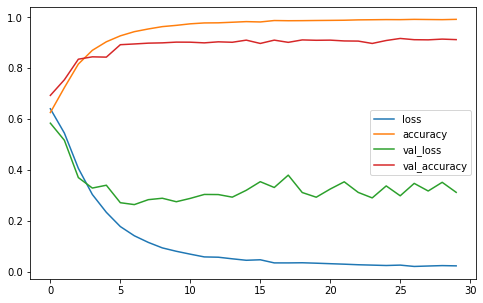

Results for fold 7
Epoch 1/30
486/486 [==============================] - 55s 111ms/step - loss: 0.6449 - accuracy: 0.6279 - val_loss: 0.5882 - val_accuracy: 0.6921
Epoch 2/30
486/486 [==============================] - 53s 110ms/step - loss: 0.5404 - accuracy: 0.7303 - val_loss: 0.4542 - val_accuracy: 0.7876
Epoch 3/30
486/486 [==============================] - 53s 110ms/step - loss: 0.3968 - accuracy: 0.8204 - val_loss: 0.3559 - val_accuracy: 0.8400
Epoch 4/30
486/486 [==============================] - 52s 107ms/step - loss: 0.2892 - accuracy: 0.8774 - val_loss: 0.3198 - val_accuracy: 0.8631
Epoch 5/30
486/486 [==============================] - 53s 110ms/step - loss: 0.2156 - accuracy: 0.9117 - val_loss: 0.2919 - val_accuracy: 0.8715
Epoch 6/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1647 - accuracy: 0.9341 - val_loss: 0.2819 - val_accuracy: 0.8895
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1283 - accuracy: 0.9502 - val_lo

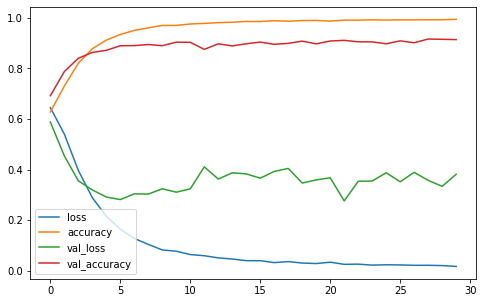

Results for fold 8
Epoch 1/30
486/486 [==============================] - 55s 111ms/step - loss: 0.6404 - accuracy: 0.6235 - val_loss: 0.6271 - val_accuracy: 0.6496
Epoch 2/30
486/486 [==============================] - 52s 107ms/step - loss: 0.5640 - accuracy: 0.7005 - val_loss: 0.5156 - val_accuracy: 0.7436
Epoch 3/30
486/486 [==============================] - 52s 107ms/step - loss: 0.4304 - accuracy: 0.7944 - val_loss: 0.4696 - val_accuracy: 0.7763
Epoch 4/30
486/486 [==============================] - 52s 108ms/step - loss: 0.3141 - accuracy: 0.8613 - val_loss: 0.3376 - val_accuracy: 0.8524
Epoch 5/30
486/486 [==============================] - 52s 108ms/step - loss: 0.2378 - accuracy: 0.8999 - val_loss: 0.3162 - val_accuracy: 0.8637
Epoch 6/30
486/486 [==============================] - 53s 110ms/step - loss: 0.1819 - accuracy: 0.9252 - val_loss: 0.3041 - val_accuracy: 0.8773
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1440 - accuracy: 0.9432 - val_lo

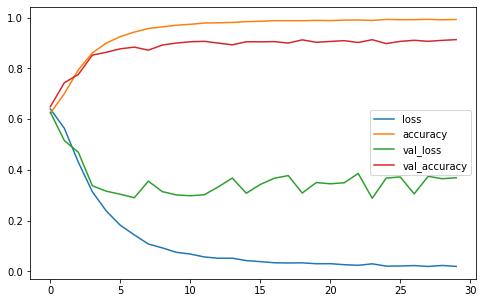

Results for fold 9
Epoch 1/30
486/486 [==============================] - 54s 108ms/step - loss: 0.6365 - accuracy: 0.6321 - val_loss: 0.5791 - val_accuracy: 0.6898
Epoch 2/30
486/486 [==============================] - 52s 108ms/step - loss: 0.5240 - accuracy: 0.7365 - val_loss: 0.4947 - val_accuracy: 0.7630
Epoch 3/30
486/486 [==============================] - 54s 110ms/step - loss: 0.3896 - accuracy: 0.8229 - val_loss: 0.3712 - val_accuracy: 0.8278
Epoch 4/30
486/486 [==============================] - 52s 108ms/step - loss: 0.2961 - accuracy: 0.8709 - val_loss: 0.3356 - val_accuracy: 0.8481
Epoch 5/30
486/486 [==============================] - 54s 110ms/step - loss: 0.2232 - accuracy: 0.9067 - val_loss: 0.3120 - val_accuracy: 0.8727
Epoch 6/30
486/486 [==============================] - 52s 108ms/step - loss: 0.1786 - accuracy: 0.9287 - val_loss: 0.3556 - val_accuracy: 0.8545
Epoch 7/30
486/486 [==============================] - 52s 107ms/step - loss: 0.1371 - accuracy: 0.9448 - val_lo

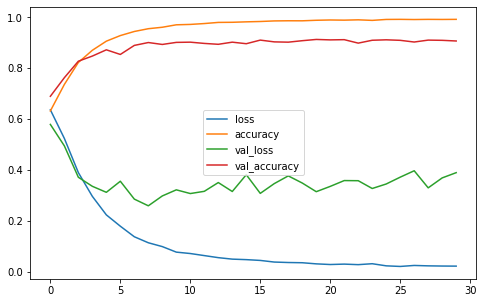

Results for fold 10
Epoch 1/30
486/486 [==============================] - 54s 108ms/step - loss: 0.6409 - accuracy: 0.6216 - val_loss: 0.5781 - val_accuracy: 0.6918
Epoch 2/30
486/486 [==============================] - 54s 110ms/step - loss: 0.5486 - accuracy: 0.7189 - val_loss: 0.4763 - val_accuracy: 0.7688
Epoch 3/30
486/486 [==============================] - 52s 108ms/step - loss: 0.4145 - accuracy: 0.8063 - val_loss: 0.4325 - val_accuracy: 0.7920
Epoch 4/30
486/486 [==============================] - 52s 108ms/step - loss: 0.3017 - accuracy: 0.8712 - val_loss: 0.3238 - val_accuracy: 0.8617
Epoch 5/30
486/486 [==============================] - 52s 108ms/step - loss: 0.2245 - accuracy: 0.9055 - val_loss: 0.2826 - val_accuracy: 0.8762
Epoch 6/30
486/486 [==============================] - 52s 108ms/step - loss: 0.1706 - accuracy: 0.9316 - val_loss: 0.3317 - val_accuracy: 0.8602
Epoch 7/30
486/486 [==============================] - 54s 110ms/step - loss: 0.1365 - accuracy: 0.9457 - val_l

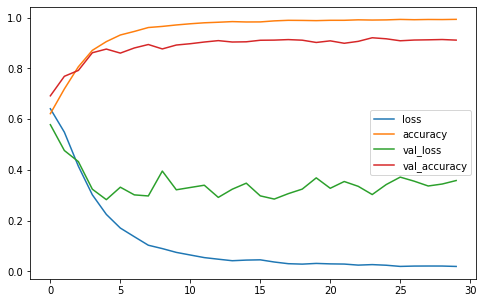

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9161458313465118
F1_Score  : 0.9137609871489973


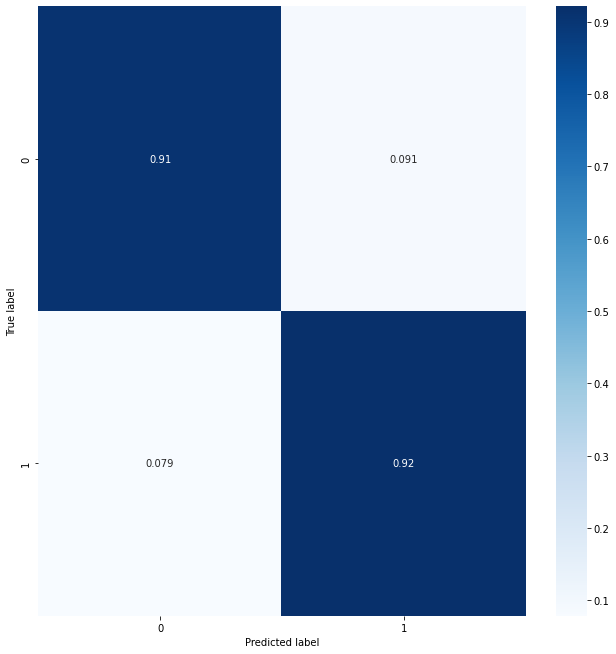

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()